This notebook shows an example of how to conduct a diffuse-flux analysis.
The core of the analysis is a binned poisson likelihood evaluation using Asimov data.
The histograms of the analysis are the effective area, the energy resolution, and the atmospheric background model.
Core functions of the PLEnuM software are used in this example.

In [1]:
%load_ext autoreload
%autoreload 2

# Files

* effective area
* background flux
* energy resolution

# Imports

In [2]:
import pickle
from os.path import join
from collections import namedtuple

import numpy as np

from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from scipy.special import erfinv
from scipy.interpolate import RegularGridInterpolator

from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Standalone Functions

In [3]:
def get_mids(bins, ext=False):
    """Calculate the bin mids from an array of bin edges."""
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext == False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res


def calc_aeff_factor(aeff, e_width, livetime, sindec_width, ra_width):
    ra_width = np.atleast_1d(ra_width)
    aeff_factor = (
        aeff * sindec_width[:, np.newaxis] * e_width * np.sum(ra_width) * livetime
    )
    return aeff_factor


def power_law(energy, e_scale, gamma, phi0):
    """Generic form of power-law spectrum: (energy / e_scale) ** (-gamma) * phi0
    energy: array
        energy values to evaluate the power-law spectrum
    e_scale: float
        normalization of the energy scale
    gamma: float (positive)
        spectral index, will be multiplied by -1
    phi0: float
        flux normalization at the given energy scale

    """
    return (energy / e_scale) ** (-gamma) * phi0


def astro_flux(
    aeff_factor,
    emids,
    energy_resolution,
    phi_scaling,
    flux_shape,
):
    flux_base = aeff_factor * power_law(
        emids, flux_shape.E0, flux_shape.gamma, flux_shape.norm * phi_scaling
    )
    return energy_smearing(energy_resolution, flux_base)


def atmo_background(aeff_factor, bckg_vals, energy_resolution):
    """Calculate the number of neutrinos of atmospheric background flux
    as a function neutrino energy or reconstructed energy.

    If aeff_factor is 2D, eg. in sin(dec) and log(E_true),
    the result will also be 2D, in sin(dec) and log(E_reco) then.

    Parameters:
    aeff_factor: array
        effective area multiplied with binning and livetime
    bckg_vals: atmospheric background flux binned the same way as aeff_factor
    energy_resolution: Optional
        If the energy resolution matrix is given,
        calculate the background events for reconstructed energy;
        If None, return background events for true neutrino energy

    """
    return energy_smearing(energy_resolution, aeff_factor * bckg_vals)


def energy_smearing(ematrix, ev):
    """Matrix multiplication with the energy resolution
    to translate an event histogram from E_true to E_reco.

    Expected formats: (need to double check ....)
    ematrix: logE_reco x logE
    ev: any x logE
    """
    return (ematrix @ ev.T).T  # returns any x logE_reco


def poisson_llh(mu_i, k_i):
    """Calculate the -2 log(Poisson LLH).

    L(data k | model mu)  = prod_{i,j} mu_ij ** k_ij / k_ij! * exp(-mu_ij)

    For numerical stability, we directly evaluate the log of the poisson probability
    (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function).

    Since we are using Asimov data that can have floating point values, we need to implement the function
    instead of using scipy.stats.poisson.logpmf. (It fails for floats in k_i!!)

    -2 log (L) = -2 [k_i log(mu_i) - mu_i - 0.5 log(2 pi k_i) + k_i - k_i log(k_i)]

    We treat some special cases that may cause problems in log:

    * mu -> 0, k>0     --> P -> 0
    * k -> 0, mu>0     --> P -> exp(-mu)
    * k -> 0, mu -> 0  --> P -> 1

    """
    log_LLH = np.zeros_like(mu_i)
    # k == 0, mu > 0:
    _mask = (k_i == 0) & (mu_i > 0)
    log_LLH[_mask] = -mu_i[_mask]
    # k == 0, mu == 0:
    _mask = (k_i == 0) & (mu_i == 0)
    log_LLH[_mask] = 0
    # k > 0, mu==0: should not happen! we'll assign a very negative value
    _mask = (k_i > 0) & (mu_i == 0)
    log_LLH[_mask] = -1e16
    # k > 0, mu > 0
    _mask = (k_i > 0) & (mu_i > 0)
    log_LLH[_mask] = (
        k_i[_mask] * np.log(mu_i[_mask])
        - mu_i[_mask]
        - 0.5 * np.log(2 * np.pi * k_i[_mask])
        + k_i[_mask]
        - k_i[_mask] * np.log(k_i[_mask])
    )

    return -2 * np.sum(log_LLH)

# Settings

In [4]:
LIVETIME = 3186 * 24 * 3600  # new ngc paper
# LIVETIME = 10 * 360 * 24 * 3600  # 360 days of data taking per year in seconds
E_NORM = 1e5  # normalization energy of power law (E/E_NORM)^gamma
# --> 100 TeV
# Diffuse nu-mu paper now available at https://arxiv.org/abs/2111.10299
GAMMA_ASTRO = 2.37
PHI_ASTRO_FACTOR = 1.44
# we use this factor such that PHI_ASTRO_FACTOR can be of order 1
PHI_0 = 1.0e-18  # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s
PHI_ASTRO = PHI_ASTRO_FACTOR * PHI_0  # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

# Science Paper parameters of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5e-14  # @ 1 TeV / GeV cm² s
E0_NGC = 1e3
# gaussian sigma values
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma2 = 1 - norm.cdf(2)
sigma1 = 1 - norm.cdf(1)

# important object coordinates
sgr_a = SkyCoord(0, 0, unit="rad", frame="galactic")
txs0506 = SkyCoord(77.36, 5.69, unit="deg", frame="icrs")
ngc1068 = SkyCoord(40.67, -0.01, unit="deg", frame="icrs")

In [5]:
# livetime of 10yrs in seconds and days
print(LIVETIME, LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(E_NORM)  # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
print(GAMMA_ASTRO)  # spectral index
print(PHI_ASTRO)  # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr

# your paths:
BASEPATH = ""
LOCALPATH = ""
print(BASEPATH)
print(LOCALPATH)


275270400 3186.0
100000.0
2.37
1.44e-18




# Get the effective area

140 log_10(energy) bins
100 declination bins
141 2.0 8.999999999999975
101 -1.0 1.0


(2.0, 9.0)

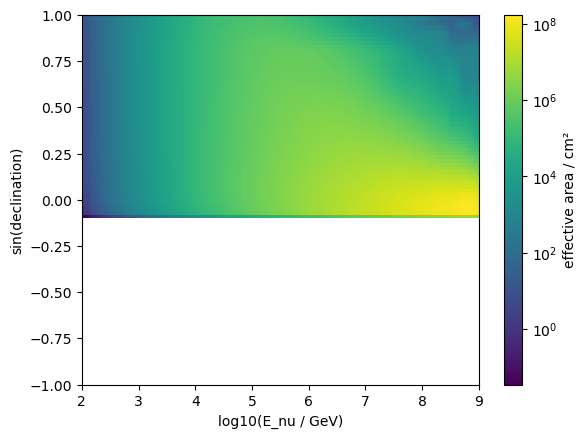

In [6]:
with open("../../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)
# get the mids of the log(true energy / GeV) binning
logE_mids = get_mids(logE_bins)
# cut all arrays at E=10⁹GeV
logE_bins = logE_bins[logE_bins<=9]
# for this demo, we only look at IceCube's effective area
aeff_2d = aeff_2d["IceCube"][logE_mids<=9]
logE_mids = logE_mids[logE_mids<=9]

# get the binning also in true energy
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

# same for sin(dec) binning
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

# Right ascension
ra_width = 2 * np.pi

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))

# plot the effective area (only up-going events)
plt.pcolormesh(logE_bins, sindec_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)



# Background

/tmp/ipykernel_1838404/4208159983.py:6: RuntimeWarning: invalid value encountered in log
  (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])


(2.0, 9.0)

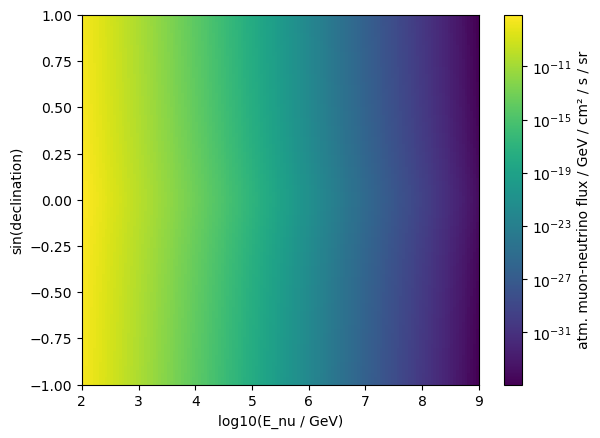

In [7]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open("../../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
bckg_rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation of the interpolation
# such that it matches the effective area binning
ss, em = np.meshgrid(sindec_mids, emids)
# bckg flux as a function of log10(true energy/GeV) and sin(dec)
bckg_flux_vals = np.exp(bckg_rgi((em, ss))).T # / GeV / cm² / s / sr



# visualization of bckg flux
plt.pcolormesh(logE_bins, sindec_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)




# Energy smearing

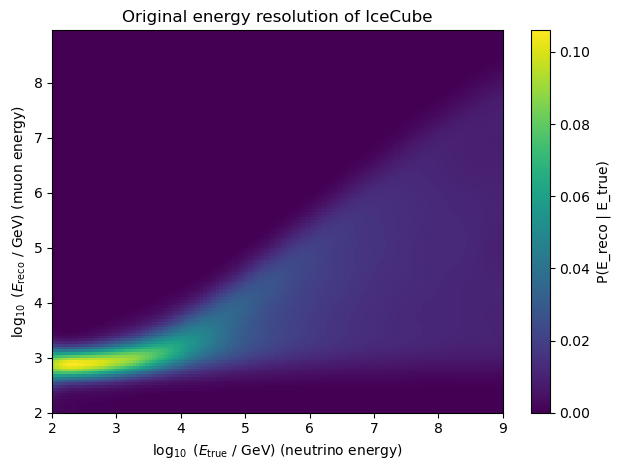

In [8]:
with open("../../resources/baseline_energy_resolution.pckl", "rb") as f:
    eres_bins, eres_axis_names, eres_histo = pickle.load(f)
eres_axis_names, eres_bins, eres_histo
# make sure bins are matching for true and reco energy

# new binning for log10(reconstructed energy)
logE_reco_bins = eres_bins[1]
logE_reco_mids = get_mids(logE_reco_bins)
# make sure to normalize the matrix per bin in true energy
baseline_eres = eres_histo.T / np.sum(eres_histo, axis=1)


# visualization of smearing matrix
f, axes = plt.subplots()

axes.grid(False)
im = axes.pcolormesh(logE_bins, logE_reco_bins, baseline_eres)
axes.set_ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
axes.set_xlim(np.min(logE_bins), np.max(logE_bins))
axes.set_title("Original energy resolution of IceCube")
axes.set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes.set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
cb = f.colorbar(im)
cb.set_label("P(E_reco | E_true)")
f.tight_layout()



# Source flux definition
$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [9]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")


# Config

In [28]:
# generic diffuse flux config
diffuse_config = dict(
    sindec_width=sindec_width,
    ra_width=ra_width,
    livetime=3 * 365 * 24 * 3600,  # 5 year
    e_width=ewidth,
)

Fit parameters for analysis:
* Global normalization of the atmospheric neutrino flux (background), $N_B$
* Global normalization of the astrophysical neutrino flux (signal), $N_S$
* Spectral index, GAMMA_ASTRO, of the astrophysical neutrino flux (signal), $\gamma$

In [29]:
aeff_factor = calc_aeff_factor(aeff_2d.T, **diffuse_config)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals, baseline_eres)
k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))
print("S+B", np.sum(k_i))


Asimov data sum:
Background: 219029.39670032702
Signal: 910.955652157103
S+B 219940.35235248416


## Plotting of the event distributions

Text(0.5, 1.0, 'Signal astrophysical flux')

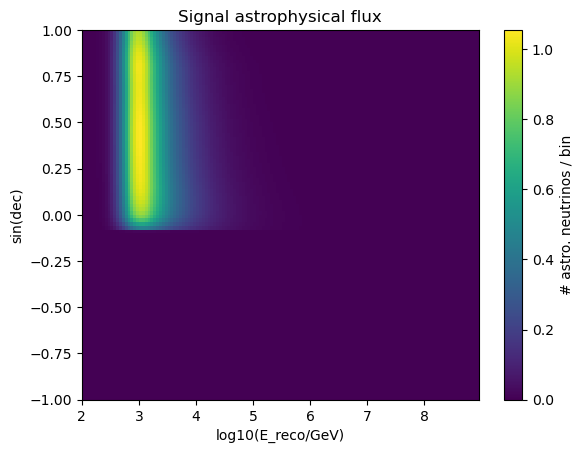

In [30]:
## signal
plt.pcolormesh(logE_reco_bins, sindec_bins, k_s)
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_reco/GeV)")

cb = plt.colorbar()
cb.set_label("# astro. neutrinos / bin")
plt.title("Signal astrophysical flux")


Text(0.5, 1.0, 'Background atmospheric flux')

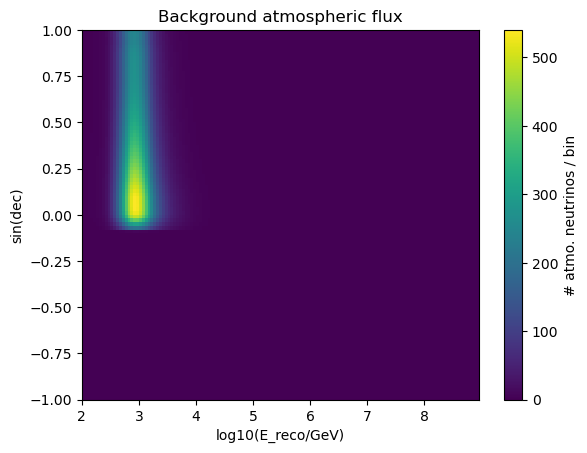

In [31]:
## atmo. background
plt.pcolormesh(logE_reco_bins, sindec_bins, k_b)
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_reco/GeV)")

cb = plt.colorbar()
cb.set_label("# atmo. neutrinos / bin")
plt.title("Background atmospheric flux")


Text(0.5, 1.0, 'Combined S+B neutrino flux')

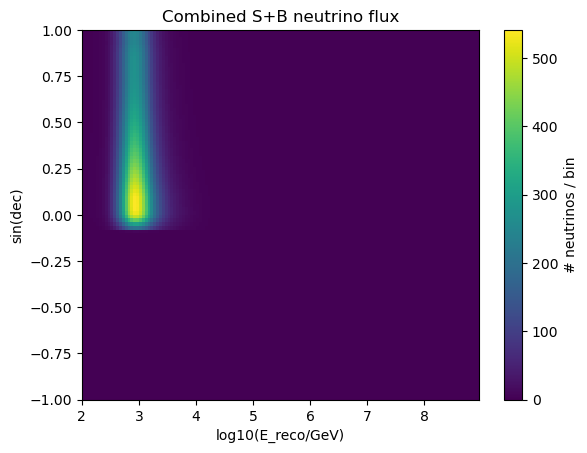

In [32]:
## atmo. background + astro. signal
plt.pcolormesh(logE_reco_bins, sindec_bins, k_i)
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_reco/GeV)")

cb = plt.colorbar()
cb.set_label("# neutrinos / bin")
plt.title("Combined S+B neutrino flux")


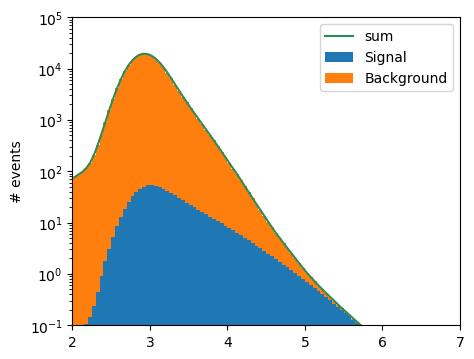

In [33]:
# summed 1D hist in log(E_reco)
f, axes = plt.subplots(figsize=(5, 4))

axes.bar(
    logE_reco_mids,
    height=k_s.sum(axis=0),
    width=np.diff(logE_reco_bins),
    bottom=0,  # if ii == 0 else mephistograms[ii - 1].histo,
    label="Signal",
)

axes.bar(
    logE_reco_mids,
    height=k_b.sum(axis=0),
    width=np.diff(logE_reco_bins),
    bottom=k_s.sum(axis=0),
    label="Background",
)

k_i_en = k_i.sum(axis=0)
plt.plot(logE_reco_mids, k_i_en, label="sum", color="seagreen")

plt.yscale("log")
plt.ylim(1e-1, 1e5)
plt.xlim(2, 7)
plt.ylabel("# events")
plt.legend()

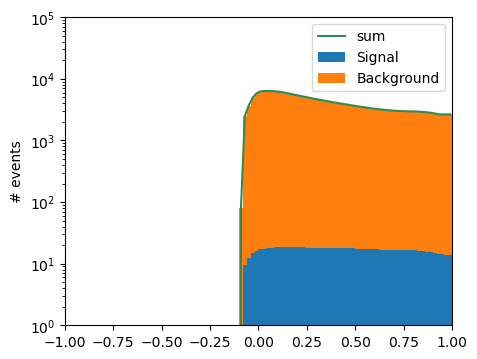

In [34]:
# summed 1D hist in sin(dec)
f, axes = plt.subplots(figsize=(5, 4))

axes.bar(
    sindec_mids,
    height=k_s.sum(axis=1),
    width=np.diff(sindec_bins),
    bottom=0, 
    label="Signal",
)

axes.bar(
    sindec_mids,
    height=k_b.sum(axis=1),
    width=np.diff(sindec_bins),
    bottom=k_s.sum(axis=1),
    label="Background",
)

k_i_en = k_i.sum(axis=1)
plt.plot(sindec_mids, k_i_en, label="sum", color="seagreen")

plt.yscale("log")
plt.ylim(1, 1e5)
plt.xlim(-1, 1)
plt.ylabel("# events")
plt.legend()


# DEMO: Significance test Background vs. Background + Signal

$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma \})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know
For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$

In [35]:
def diffuse_llh_2d(
    x,
    mu_b_base,
    aeff_factor_s,
    k_i,
    e_0=E_NORM,
):
    """
    Define the Log-Likelihood function depending
    on the model parameters (=fit parameters)

    Fit parameters:
    ---------------
    (= x) for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    Other parameters:
    -----------------
    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy
    """

    mu_b = mu_b_base * x[0]

    mu_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=x[1],
        flux_shape=PL_flux(
            PHI_ASTRO, *x[2:], e_0, "powerlaw"
        ),  # here we generate a flux tuple with the current parameters
    )
    return poisson_llh(mu_b + mu_s, k_i)


The significance of the hypothesis test is evaluated using the test statistic

$TS = -2 \log ( H_0(\mu = {\rm best fit}) / H_1(\mu = {\rm best fit}) )$

where the best-fit parameters are obtained with an optimization function `fmin_l_bfgs_b`.


The data (k) is modeled as 'Asimov data', the TS calculation fulfills the requirements of Wilks' theorem, and thus we know that the underlying TS distribution
follows a $\chi ^2$ distribution, here with 2 degrees of freedom.

The p-value of the Asimov data set represents the expected significance of an analysis with real data if it has the same model parameters. It's the integral of the $\chi ^2$ distribution from TS to infinity (`chi.sf(TS)`). The p-value in terms of Gaussian standard deviations can be calculated via the inverse survival function of the normal distribution (`norm.isf(pvalue)`).

In [36]:
aeff_factor = calc_aeff_factor(aeff_2d.T, **diffuse_config)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals, baseline_eres)
k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))
print("S+B", np.sum(k_i))

# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: diffuse_llh_2d((x[0], 0, 2), k_b, aeff_factor, k_i)
# background + signal, 3 free parameters
global_llh = lambda x: diffuse_llh_2d(x, k_b, aeff_factor, k_i)
# ... and fit both hypotheses!
# background first
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])
# .. then signal+background
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

## Note: out_bckg/comp[1] contains the value of the
# LLH function with the optimized model parameters
# out_bckg[1] - out_comp[1] == -2log(L(H_0) / L(H_1)) = TS (see above)

# calculate p-value and significance with Wilks' theorem and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
# ... we do quite well without accounting for systematic uncertainties :D

Asimov data sum:
Background: 219029.39670032702
Signal: 910.955652157103
S+B 219940.35235248416
Bckg-only normalization: [1.00415906]
Signal fit parameters: [0.99999982 1.00000826 2.36999389]
P-VALUE: 1.0159883486853884e-08 SIGNIFICANCE: 5.609256503355686
